# 学生消费聚类和低消费学生消费分析

根据学生过的整体校园消费行为，选择合适的特征，构建聚类模型，分析每一类学生群体的消费特点。找出低消费的学生，通过对低消费学生群体进行分析，探讨他们是否存在某些特征，能为学校助学金评定提供参考，也可以为学校找出需要帮助的学生

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
#提高分辨率
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置默认字体为 SimHei
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
import seaborn as sns

In [2]:
data1=pd.read_csv('task1_2_1.csv',encoding='gbk')
data1.head()

,序号,校园卡号,性别,专业名称,门禁卡号,流水号,校园卡编号,消费时间,消费金额,存储金额,余额,消费次数,消费类型,消费项目编码,操作编码,消费地点
0,1,180001,男,18国际金融,19762330,117331517.0,20181.0,2019-04-21 18:30:00,7.0,0.0,28.4,206.0,消费,41.0,249.0,第四食堂
1,1,180001,男,18国际金融,19762330,117341866.0,20181.0,2019-04-22 09:40:00,3.5,0.0,24.9,207.0,消费,19.0,236.0,第一食堂
2,1,180001,男,18国际金融,19762330,117154618.0,20181.0,2019-04-10 16:42:00,11.0,0.0,2.7,189.0,消费,82.0,18.0,第四食堂
3,1,180001,男,18国际金融,19762330,117200032.0,20181.0,2019-04-15 11:43:00,7.0,0.0,43.2,192.0,消费,62.0,2.0,第四食堂
4,1,180001,男,18国际金融,19762330,117206146.0,20181.0,2019-04-15 07:50:00,2.5,0.0,50.2,191.0,消费,2.0,236.0,第一食堂


In [3]:
data2=pd.read_csv('task1_2_2.csv',encoding='gbk')
data2.head()

,序号_x,校园卡号,性别,专业名称,门禁卡号,序号_y,进出时间,进出地点,是否通过,描述通过
0,41,180041,女,18国际金融,19748650,1346249.0,2019-04-02 09:46:00,青鸾苑[出门],1.0,允许通过
1,41,180041,女,18国际金融,19748650,1346258.0,2019-04-02 10:31:00,青鸾苑[进门],1.0,允许通过
2,41,180041,女,18国际金融,19748650,1346260.0,2019-04-02 00:00:00,青鸾苑[出门],1.0,允许通过
3,101,180101,女,18会计,18840522,1337058.0,2019-04-07 21:09:00,飞凤轩[进门],1.0,允许通过
4,101,180101,女,18会计,18840522,1344564.0,2019-04-29 14:52:00,飞凤轩[出门],1.0,允许通过


In [4]:
data1.sort_values(by=['校园卡号', '消费时间'], inplace=True)
data1 = data1.reset_index(drop=True).reset_index()

In [5]:
data1['消费时间'] = pd.to_datetime(data1['消费时间'])
data1['day'] = data1['消费时间'].dt.day.astype(int)
data1['hour'] = data1['消费时间'].dt.hour.astype(int)
data1['minute'] = data1['消费时间'].dt.minute.astype(int)

In [6]:
#检测重复消费
stu_no = data1['校园卡号'].unique().tolist()
del_index0 = []
for i in stu_no:
    sd = data1[(data1['校园卡号'] == i) & (data1['消费类型'] == '消费')]
    day_list = sd['day'].unique().tolist()
    for j in day_list:
        dd = sd[sd['day'] == j]
        for m in range(len(dd) - 1):
            for n in range(m + 1, len(dd)):
                time_diff = (dd.iloc[n]['消费时间'] - dd.iloc[m]['消费时间']).total_seconds() / 60
                if time_diff <= 5:
                    del_index0.append(dd.iloc[n]['index'])

In [7]:
data1['是否重复消费'] = False
data1.loc[data1['index'].isin(del_index0), '是否重复消费'] = True

### 特征构建

In [8]:
#排除掉非消费记录
valid_consume = data1[(data1['消费类型'] == '消费') & (~data1['是否重复消费'])]

In [9]:
student_features = valid_consume.groupby('校园卡号').agg(
    mean_consum=('消费金额', 'mean'), #每个学生的平均消费金额
    total_count=('校园卡号', 'count'), #每个学生的消费次数
    last_balance=('余额', 'last') #最后一次消费后的余额
).reset_index()
student_features.columns=["校园卡号","平均消费金额","总消费次数","最后余额"]
student_features.head()

,校园卡号,平均消费金额,总消费次数,最后余额
0,180001,5.446429,28,38.2
1,180002,3.325000,20,14.5
2,180004,6.394286,70,62.7
3,180005,6.208333,24,65.9
4,180006,4.557143,7,17.9


In [10]:
from sklearn.preprocessing import StandardScaler

# 选择需要标准化的列
numeric_cols = ["平均消费金额", "总消费次数", "最后余额"]

# 初始化标准化器
scaler = StandardScaler()

# 对数值列进行标准化
student_features[numeric_cols] = scaler.fit_transform(student_features[numeric_cols])
student_features.head()

,校园卡号,平均消费金额,总消费次数,最后余额
0,180001,0.032894,-0.843785,-0.426046
1,180002,-0.200737,-1.214150,-0.819449
2,180004,0.137281,1.100630,-0.019364
3,180005,0.116802,-1.028968,0.033753
4,180006,-0.065042,-1.815993,-0.763011


In [11]:
import copy
deal=copy.deepcopy(student_features)
deal.head()

,校园卡号,平均消费金额,总消费次数,最后余额
0,180001,0.032894,-0.843785,-0.426046
1,180002,-0.200737,-1.214150,-0.819449
2,180004,0.137281,1.100630,-0.019364
3,180005,0.116802,-1.028968,0.033753
4,180006,-0.065042,-1.815993,-0.763011


In [12]:
from sklearn.cluster import KMeans
model=KMeans(n_clusters=5,random_state=42).fit(deal)

In [13]:
deal['type']=model.labels_
pd.DataFrame(model.labels_).value_counts()

0
2    694
4    660
0    633
3    617
1    599
Name: count, dtype: int64

In [14]:
#聚类的中心
model.cluster_centers_

array([[ 1.82230041e+05, -3.10553743e-02,  2.23220647e-02,
        -1.92266244e-02],
       [ 1.83910594e+05,  5.93928838e-02, -3.11039359e-01,
        -9.16120196e-02],
       [ 1.80431170e+05, -1.07889799e-01,  1.01071814e-01,
         6.94544030e-02],
       [ 1.83054765e+05,  9.81786630e-02, -1.08458183e-01,
        -1.98795366e-02],
       [ 1.81388556e+05, -2.59776329e-03,  2.58078122e-01,
         4.76603075e-02]])

In [15]:
deal.head()

,校园卡号,平均消费金额,总消费次数,最后余额,type
0,180001,0.032894,-0.843785,-0.426046,2
1,180002,-0.200737,-1.214150,-0.819449,2
2,180004,0.137281,1.100630,-0.019364,2
3,180005,0.116802,-1.028968,0.033753,2
4,180006,-0.065042,-1.815993,-0.763011,2


### 分析

In [16]:
#簇特征统计
cluster_stats = deal.groupby('type').agg({
    '平均消费金额': ['mean', 'median'],
    '总消费次数': ['mean', 'median'],
    '最后余额': ['mean', 'median']
})
print(cluster_stats)

        平均消费金额               总消费次数                最后余额          
          mean    median      mean    median      mean    median
type                                                            
0    -0.030941 -0.056896  0.024275  0.082127 -0.020031 -0.279973
1     0.060216 -0.046271 -0.312507 -0.334534 -0.090889 -0.270013
2    -0.107890 -0.141287  0.101072  0.128422  0.069454 -0.143859
3     0.097590 -0.004857 -0.108158 -0.056760 -0.019177 -0.258394
4    -0.002760 -0.050602  0.255174  0.359900  0.046596 -0.160458


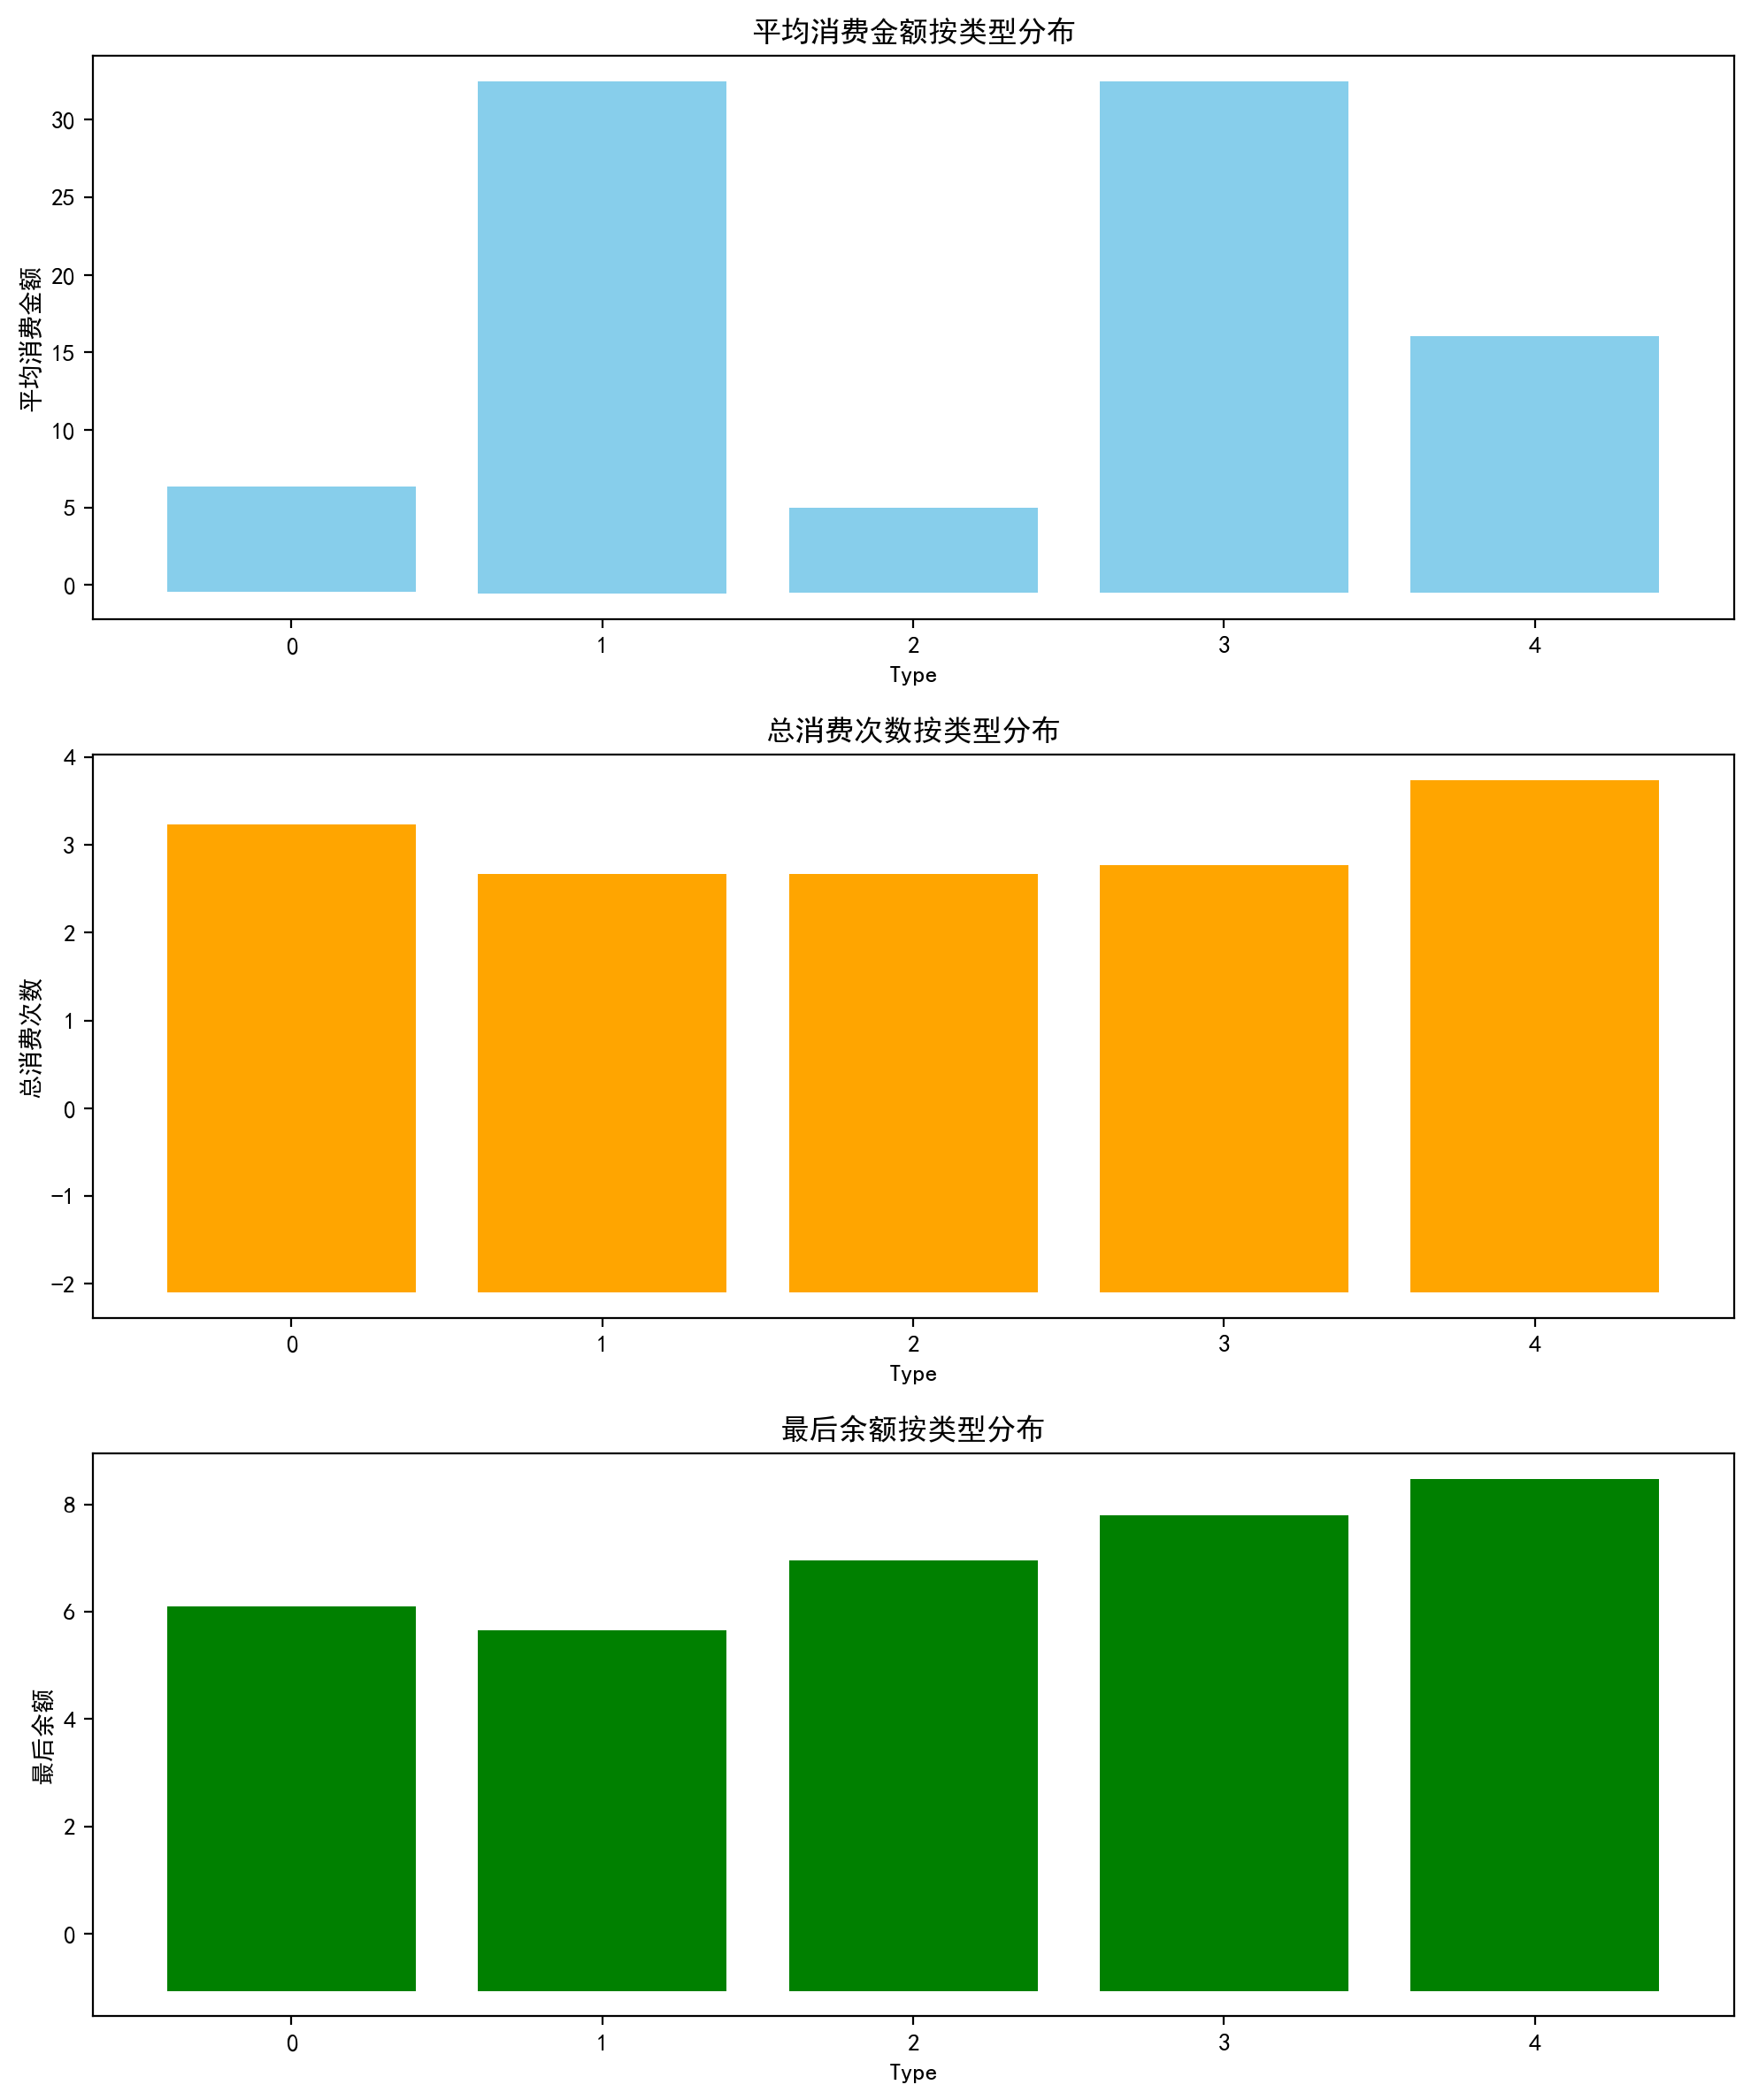

In [23]:
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# 第一个子图：平均消费金额
axs[0].bar(deal['type'], deal['平均消费金额'], color='skyblue')
axs[0].set_title('平均消费金额按类型分布')
axs[0].set_xlabel('Type')
axs[0].set_ylabel('平均消费金额')

# 第二个子图：总消费次数
axs[1].bar(deal['type'], deal['总消费次数'], color='orange')
axs[1].set_title('总消费次数按类型分布')
axs[1].set_xlabel('Type')
axs[1].set_ylabel('总消费次数')

# 第三个子图：最后余额
axs[2].bar(deal['type'], deal['最后余额'], color='green')
axs[2].set_title('最后余额按类型分布')
axs[2].set_xlabel('Type')
axs[2].set_ylabel('最后余额')

# 调整子图之间的间距
plt.tight_layout()

# 显示图表
plt.show()

**类别 0：低频低消费群体**

消费频率和金额均较低，余额较少。可能是经济条件有限或消费需求较低的学生群体

**类别 1：低频低余额群体**

消费频率低，余额较少，但单次消费金额较高。可能是偶尔高消费但整体消费较少的学生群体

**类别 2：低频中等余额群体**

消费频率和金额均较低，但余额相对较高。可能是储蓄型学生，消费较为保守    

**类别 3：高消费群体**

单次消费金额和余额较高，但消费频率较低。可能是高消费但频率不高的学生群体。 

**类别 4：高频消费群体**

消费频率高，但单次消费金额较低。可能是日常消费较多但单笔消费较小的学生群体。 

**若学校需要找到低消费贫困学生，可以继续探究类别0和类别1**

In [17]:
# 合并聚类标签到 data1
data1_with_type = pd.merge(
    deal[["type","校园卡号","平均消费金额","总消费次数","最后余额"]],
    data1,
    on='校园卡号',
    how='left'
)
data1_with_type.head(5)

,type,校园卡号,平均消费金额,总消费次数,最后余额,index,序号,性别,专业名称,门禁卡号,...,余额,消费次数,消费类型,消费项目编码,操作编码,消费地点,day,hour,minute,是否重复消费
0,2,180001,0.032894,-0.843785,-0.426046,0,1,男,18国际金融,19762330,...,41.2,182.0,消费,72.0,250.0,第四食堂,2,11,40,False
1,2,180001,0.032894,-0.843785,-0.426046,1,1,男,18国际金融,19762330,...,48.2,181.0,消费,105.0,236.0,第一食堂,4,7,38,False
2,2,180001,0.032894,-0.843785,-0.426046,2,1,男,18国际金融,19762330,...,25.2,185.0,消费,82.0,18.0,第四食堂,8,11,26,False
3,2,180001,0.032894,-0.843785,-0.426046,3,1,男,18国际金融,19762330,...,20.2,186.0,消费,61.0,252.0,第四食堂,8,17,28,False
4,2,180001,0.032894,-0.843785,-0.426046,4,1,男,18国际金融,19762330,...,18.2,187.0,消费,19.0,235.0,第一食堂,9,9,27,False


In [19]:
valid_locations = ['第一食堂', '第二食堂', '第三食堂', '第四食堂', '第五食堂']
data1_with_type_filtered = data1_with_type[data1_with_type['消费地点'].isin(valid_locations)]

# 计算每个聚类类型的消费地点占比
location_percentage = data1_with_type_filtered.groupby(['type', '消费地点']).size().unstack(fill_value=0)
location_percentage = location_percentage.div(location_percentage.sum(axis=1), axis=0)
location_percentage

消费地点,第一食堂,第三食堂,第二食堂,第五食堂,第四食堂
type,,,,,
0,0.114506,0.153906,0.243536,0.358117,0.129934
1,0.098250,0.137341,0.263125,0.404945,0.096339
2,0.137146,0.119331,0.345792,0.296711,0.101020
3,0.145296,0.149443,0.248265,0.328849,0.128147
4,0.203966,0.009062,0.546186,0.018531,0.222254


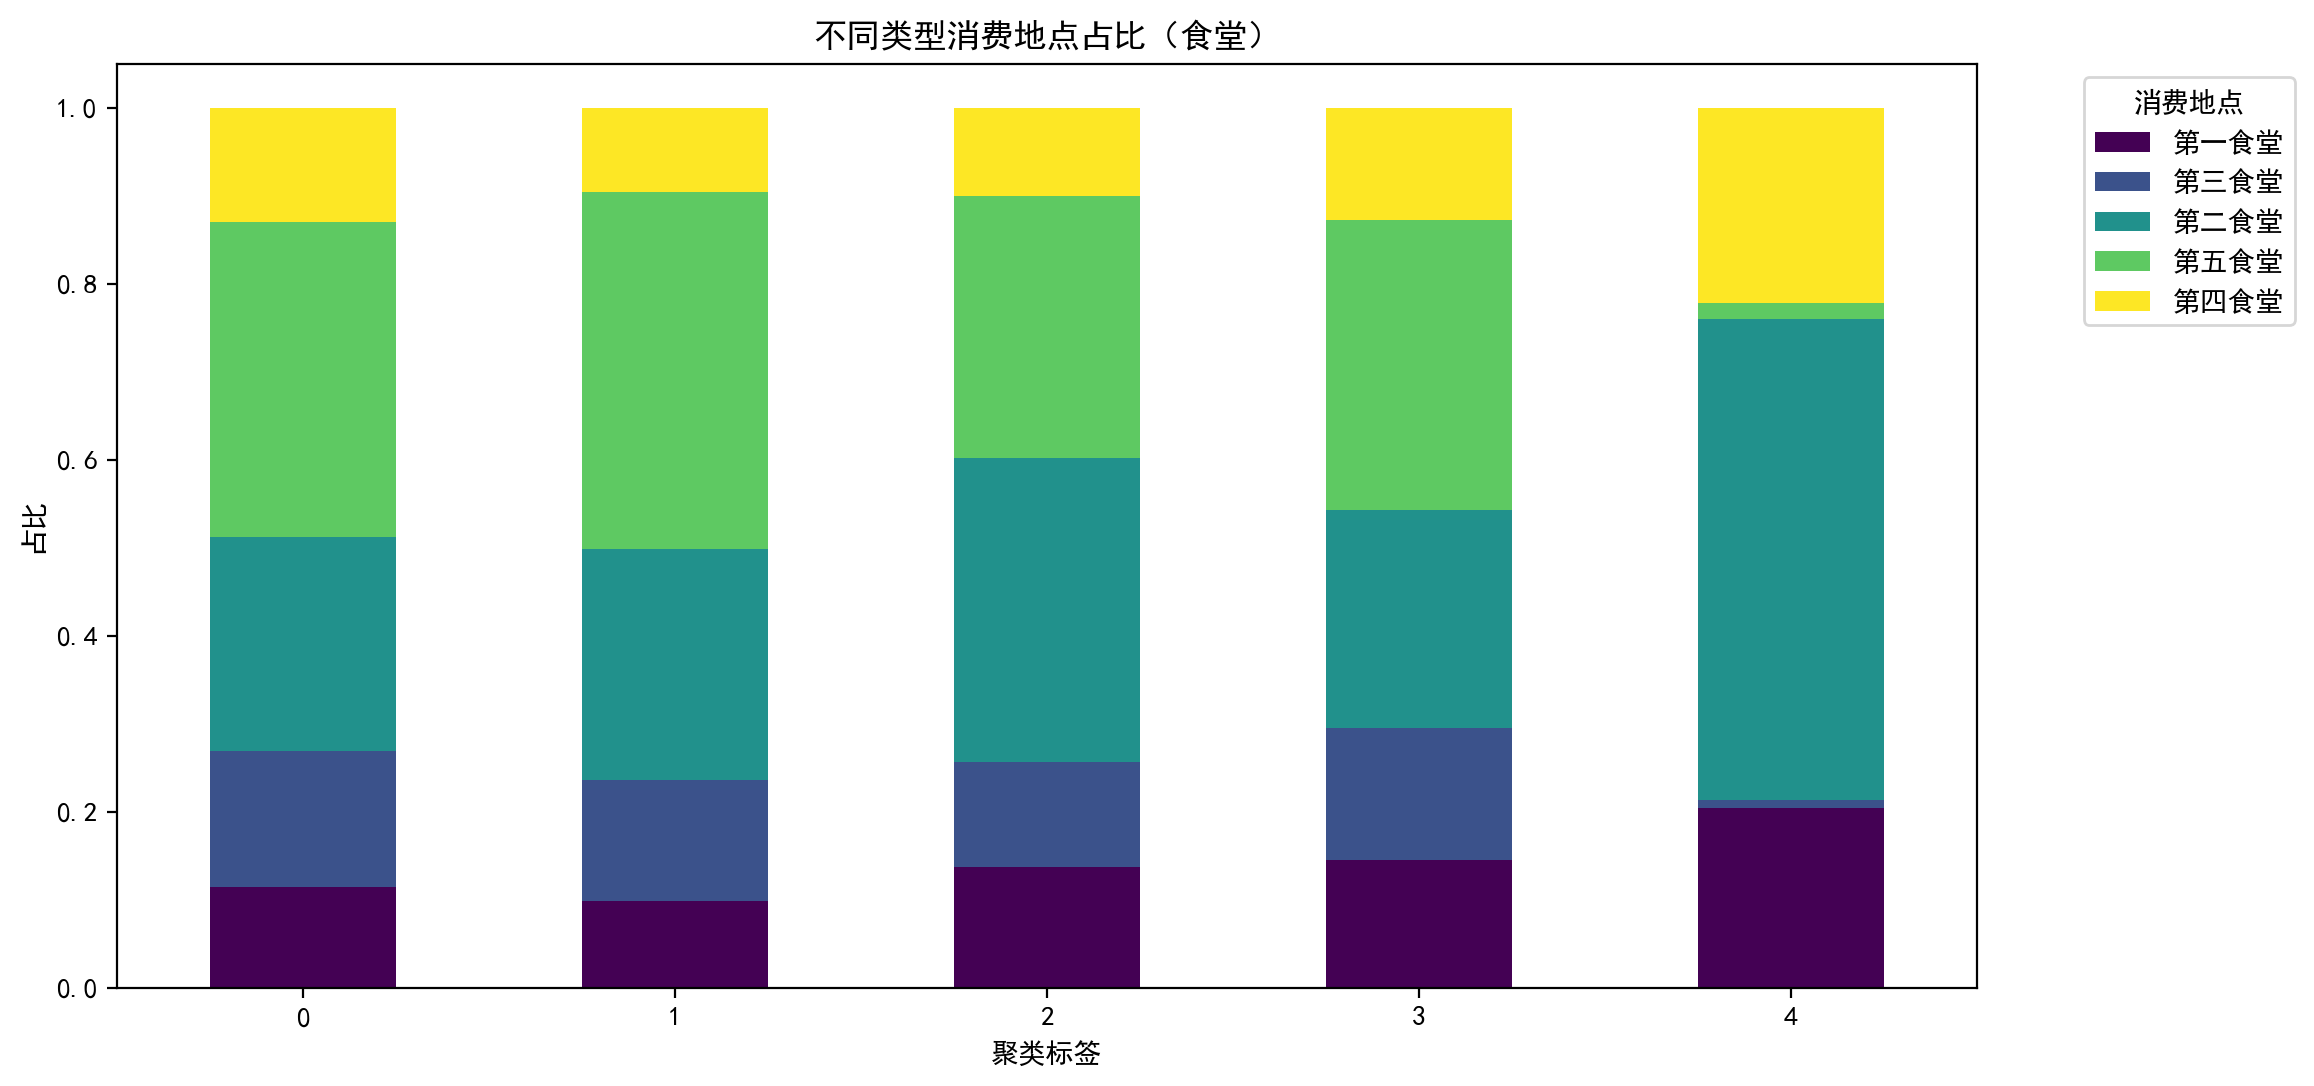

In [20]:
# 绘制堆叠柱状图
location_percentage.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('不同类型消费地点占比（食堂）')
plt.xlabel('聚类标签')
plt.ylabel('占比')
plt.xticks(rotation=0)
plt.legend(title='消费地点', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

根据食堂可视化部分可知：

食堂4和食堂3的价格显著高于别的食堂

食堂2和食堂5的客单价低，且流量也高

客单价(从低到高)排名：2-1-5-3-4

流量排名（从小到大）:3-4-1-5-2

**类别 4：**

在食堂 2 的消费占比最高（54.62%），且食堂 2 的客单价最低。

结合上述分析，这类学生大概是存储型学生。

**类别 0 和类别 1：**

在食堂 5 的消费占比较高（35.81% 和 40.49%），食堂 5 的客单价较低。

结合上述分析，这类学生也可能是经济条件较差以及一般的学生群体。

**类别 3：**

在食堂 4 和食堂 3 的消费占比较高，这些食堂价格较高。

这类学生可能是经济条件较好的学生群体。

## 学校贫困生识别

重点关注类别0,1，以及类别4：

这些学生在低价格食堂（食堂 2 和食堂 5）的消费占比较高，且消费金额较低，可能是经济有限的学生，但是类别2还需要根据数据再继续深挖以区分

优先资助类别 0、类别 1和部分类别 4：

这些学生在低价格食堂的消费占比较高，且消费金额较低，可能是经济困难的学生。

可以优先为他们提供助学金或食堂消费补贴。

**提供定向消费补贴：**

为贫困生提供在食堂 2 和食堂 5 的消费补贴，降低他们的生活成本。

**动态调整助学金：**

定期分析学生的消费行为变化，动态调整助学金分配，确保资助的精准性。